In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from transformers import (
    BertTokenizer,
    TFBertMainLayer,
    TFBertPreTrainedModel,    
)

tf.random.set_seed(42)

In [ ]:
#讀入SST-2影評文本集, 並對輸入文字序列進行預處理
data_source = "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv"
df = pd.read_csv(data_source, delimiter="\t", header=None)
df.rename(columns={0: "reviews", 1: "label"}, inplace=True)


smaller_batch = df[:2000]

label_series = smaller_batch["label"]

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
tokenized = smaller_batch["reviews"].apply(
    (lambda review: tokenizer.encode(review, add_special_tokens=True))
)


max_len = np.max([len(tokenized_review) for tokenized_review in tokenized])
min_len = np.min([len(tokenized_review) for tokenized_review in tokenized])
avg_len = np.mean([len(tokenized_review) for tokenized_review in tokenized])
print("The length of the longest review:", max_len)
print("The length of the shortest review:", min_len)
print("The average length of all the reviews:", avg_len)

shortest_reviews = [
    tokenized_review for tokenized_review in tokenized if len(tokenized_review) == 3
]
print(shortest_reviews, "\n")
for review in shortest_reviews:
    print(tokenizer.convert_ids_to_tokens(review, skip_special_tokens=False))

padded_ids = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded_ids != 0, 1, 0)


label = label_series.to_numpy()
label = to_categorical(label, num_classes=2)

The length of the longest review: 59
The length of the shortest review: 3
The average length of all the reviews: 23.823
[[101, 10166, 102], [101, 2053, 102], [101, 9202, 102], [101, 6659, 102]] 

['[CLS]', 'wow', '[SEP]']
['[CLS]', 'no', '[SEP]']
['[CLS]', 'horrible', '[SEP]']
['[CLS]', 'terrible', '[SEP]']


In [ ]:
#更改TFBertForSequenceClassification類別其內訓練分類器所使用的輸入向量
#使用輸入樣本的所有輸出hidden_state vectors的平均作為特徵向量

class TFBertForSequenceClassification(TFBertPreTrainedModel):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.num_labels = config.num_labels
        self.token_index = 0  # token_index:0 代表[CLS] token
        self.bert = TFBertMainLayer(config, name="bert")
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(config.num_labels)    

    def call(self, inputs, **kwargs):
      outputs = self.bert(inputs, **kwargs)
      last_hidden_state = outputs.last_hidden_state
      # 平均特徵
      pooled_output = tf.math.reduce_mean(last_hidden_state, axis=1)  
      pooled_output = self.dropout(pooled_output, training=kwargs.get("training", False))
      logits = self.classifier(pooled_output)

      #230511 edit  
      return {'logits': logits} #dict型態


model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dense', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

#230511 edit  
inputs = (padded_ids, attention_mask) 
outputs = {'logits': label}

history = model.fit(inputs, outputs, batch_size=32, epochs=10, validation_split=0.2 )

Epoch 1/10


50/50 [==============================] - 70s 521ms/step - loss: 0.4597 - accuracy: 0.7925 - val_loss: 0.2919 - val_accuracy: 0.8925
Epoch 2/10
50/50 [==============================] - 23s 456ms/step - loss: 0.1519 - accuracy: 0.9488 - val_loss: 0.2725 - val_accuracy: 0.8750
Epoch 3/10
50/50 [==============================] - 22s 436ms/step - loss: 0.0493 - accuracy: 0.9837 - val_loss: 0.3802 - val_accuracy: 0.8800
Epoch 4/10
50/50 [==============================] - 22s 434ms/step - loss: 0.0277 - accuracy: 0.9925 - val_loss: 0.6034 - val_accuracy: 0.8500
Epoch 5/10
50/50 [==============================] - 25s 496ms/step - loss: 0.0365 - accuracy: 0.9894 - val_loss: 0.4456 - val_accuracy: 0.8825
Epoch 6/10
50/50 [==============================] - 24s 478ms/step - loss: 0.0175 - accuracy: 0.9962 - val_loss: 0.4548 - val_accuracy: 0.8575
Epoch 7/10
50/50 [==============================] - 22s 438ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.5945 - val_accuracy: 0.8650
Epoch 8/10

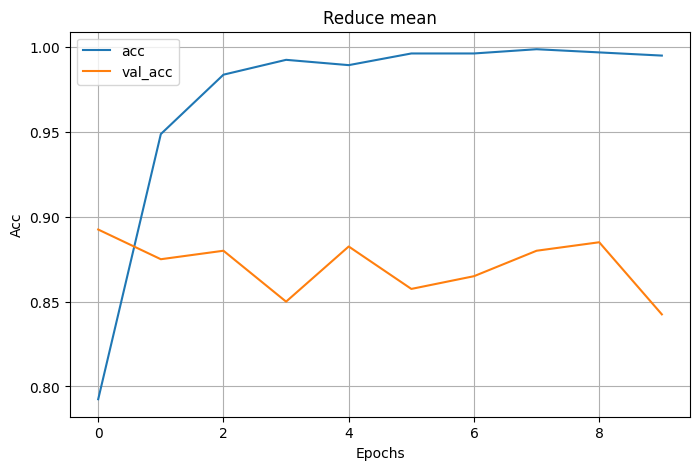

In [ ]:
#test
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Reduce mean")
plt.legend()
plt.show()

In [ ]:
#更改TFBertForSequenceClassification類別其內訓練分類器所使用的輸入向量
#使用輸入樣本的 第token_index個 輸出hidden_state vector作為特徵向量

class TFBertForSequenceClassification(TFBertPreTrainedModel):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.num_labels = config.num_labels
        self.token_index = 0  # token_index:0 代表[CLS] token
        self.bert = TFBertMainLayer(config, name="bert")
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(config.num_labels)

    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)
        last_hidden_state = outputs.last_hidden_state
        # 取[CLS] token特徵
        pooled_output = last_hidden_state[:, self.token_index]
        # print("pooled_output.shape", pooled_output.shape)  # batch_size * 768
        pooled_output = self.dropout(
            pooled_output, training=kwargs.get("training", False)
        )
        logits = self.classifier(pooled_output)
        
        #230511 edit  
        return {'logits': logits} #dict型態


model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
model.token_index = 2 # 預設0是[CLS] token, 我們可以在這裡改為其它的，如2

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_151', 'dense_3']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

#230511 edit  
inputs = (padded_ids, attention_mask) 
outputs = {'logits': label}

history = model.fit(inputs, outputs, batch_size=32, epochs=10, validation_split=0.2 )

Epoch 1/10


50/50 [==============================] - 76s 469ms/step - loss: 0.4848 - accuracy: 0.7625 - val_loss: 0.3135 - val_accuracy: 0.8850
Epoch 2/10
50/50 [==============================] - 20s 403ms/step - loss: 0.2129 - accuracy: 0.9219 - val_loss: 0.2802 - val_accuracy: 0.8800
Epoch 3/10
50/50 [==============================] - 20s 408ms/step - loss: 0.0588 - accuracy: 0.9806 - val_loss: 0.4186 - val_accuracy: 0.8650
Epoch 4/10
50/50 [==============================] - 21s 430ms/step - loss: 0.0281 - accuracy: 0.9925 - val_loss: 0.4239 - val_accuracy: 0.8850
Epoch 5/10
50/50 [==============================] - 21s 426ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.5750 - val_accuracy: 0.8900
Epoch 6/10
50/50 [==============================] - 20s 393ms/step - loss: 0.0284 - accuracy: 0.9881 - val_loss: 0.4162 - val_accuracy: 0.8950
Epoch 7/10
50/50 [==============================] - 21s 419ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.5658 - val_accuracy: 0.8950
Epoch 8/10

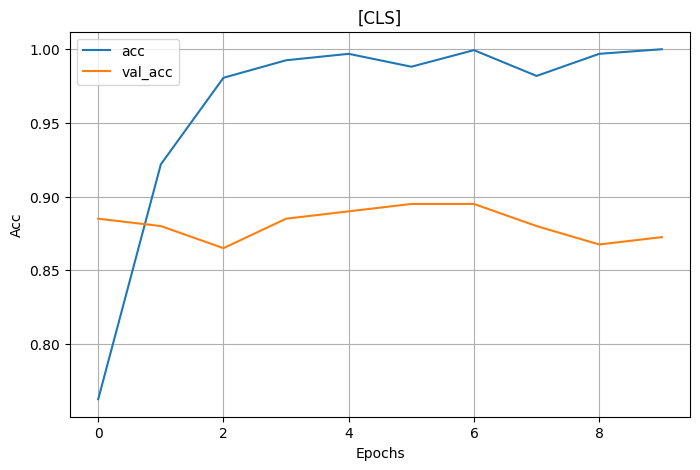

In [ ]:
# test
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("[CLS]")
plt.legend()
plt.show()